# TP5 - Máquina de vectores soporte (SVM)

**Alumna**: Lucia Berard

**Fecha**: 27/04/2025


[Link a Google Colab](https://colab.research.google.com/drive/1FbuNZhN6I-LDuyQaoEt2PP1aSK4a9Z0o?usp=sharing)

Este ejercicio trata sobre clasificación mediante máquinas de vectores soporte (SVM) aplicado a un dataset de géiseres de Yellowstone

Un `géiser` es un tipo especial de fuente hidrotermal que emite esporádicamente una columna de agua caliente y vapor al aire. Se desea clasificar el tipo de erupción de Yellowstone National Park (EEUU) a partir del tiempo de espera hasta la erupción y la duración de la misma.

![geiser](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Geyser_diagram_lmb.png/250px-Geyser_diagram_lmb.png) 
<!-- ![geiser2](https://ingeoexpert.com/wp-content/uploads/2020/02/geiser-2-845x684.jpg) -->

In [27]:
%pip install qpsolvers
%pip install qpsolvers[cvxopt]
%pip install osqp
%pip install cvxopt


You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: qpsolvers[cvxopt]
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from qpsolvers import solve_qp


___
### (a) Base de datos: Cargar la base de datos utilizando `load_dataset('geyser')` (seaborn).

Esta base de datos contiene tres columnas:

- duration: duración de la erupción en minutos.

- waiting: tiempo de espera hasta la siguiente erupción en minutos.

- kind: tipo de erupción ("short" o "long")


[Mas informacion de load_dataset](https://www.geeksforgeeks.org/python-seaborn-load_dataset-method/)

Necesito preparar los datos del dataset:

- **X**: Toma dos columnas del dataset geyser: waiting y duration. `.values` convierte el DataFrame de pandas en un array de NumPy. X es ahora una matriz de tamaño (n_samples, 2), donde cada fila es un punto de datos (espera y duración).

- **y**: Define las etiquetas de clasificación: Si el kind == short, la etiqueta es -1 (corta). Si no, es +1 (larga). 

   duration  waiting   kind
0     3.600       79   long
1     1.800       54  short
2     3.333       74   long
3     2.283       62  short
4     4.533       85   long


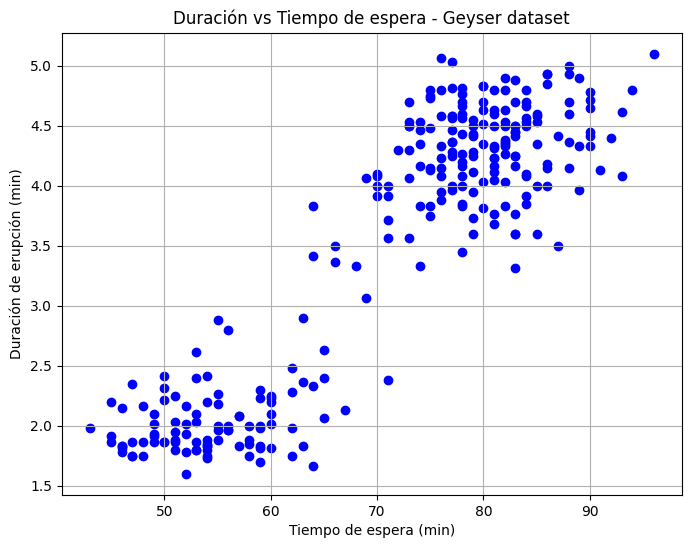

In [29]:
# Cargar la base de datos
geyser = sns.load_dataset('geyser')

# Mostrar las primeras
#  filas
print(geyser.head())

# scatter plot para visualizar mejor el dataset
plt.figure(figsize=(8, 6))
plt.scatter(geyser['waiting'], geyser['duration'], c='blue', alpha=1)
plt.title('Duración vs Tiempo de espera - Geyser dataset')
plt.xlabel('Tiempo de espera (min)')
plt.ylabel('Duración de erupción (min)')
plt.grid(True)
plt.show()

X = geyser[['waiting', 'duration']].values

y = np.where(geyser['kind'] == 'short', -1, 1)



___
### (b) Clasificacion SVM
Implementar una clasificación SVM utilizando `solve_qp` (qpsolvers), resolviendo el problema primal. El código debe estar estructurado de la siguiente manera:

```python
class svm:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, ...):

    # Etapa de entrenamiento
    def fit(self, X, y):

    # Etapa de testeo
    def predict(self, X):
```
Graficar la frontera de decisión y las rectas de vectores soportes sobre un `scatter`.

[Mas informacion de solve_qp](https://pypi.org/project/qpsolvers/)


#### 🧠 Primero: ¿qué es un SVM?

Es un algoritmo que busca una recta (o plano) que separe dos clases de puntos y lo hace tratando de alejarse lo más posible de los puntos más cercanos de cada clase. Esa distancia se llama margen.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/400px-SVM_margin.png" alt="SVM" width="400" />

- **\( w \)**:
  - Es **el vector normal** al hiperplano de separación.
  - Define **la dirección e inclinación** de la frontera de decisión.

- **\( b \)**:
  - Es **el sesgo** (o bias).
  - Define **el desplazamiento** del hiperplano (lo corre hacia arriba o abajo).


#### 🧠 Dual? Primal? Margenes duros o blandos? 
Los distintos algoritmos se pueden clasificar en: 

1. SVM con márgenes duros (primal): Acá suponemos que los puntos se pueden separar perfecto, sin errores.

2. SVM con márgenes duros (dual): Acá se cambia el problema para trabajar con unos valores nuevos llamados $\alpha$, que solo existen para los puntos importantes (los vectores soporte).

3. SVM con márgenes blandos (relajados) – primal: ¿Qué pasa si los puntos no se pueden separar bien? Bueno, en este caso aceptamos algunos errores, pero los penalizamos con una letra $C$ que yo puedo elegir
    - Si C es grande, el modelo es estricto → busca separar todo sin errores.

    - Si C es chico, el modelo es más flexible → se adapta mejor si hay ruido o solapamiento.

4. SVM con márgenes blandos (dual): Igual que antes, pero ahora los $\alpha$ tienen un límite superior

🎓 Entonces:
- Márgen duro = quiero separar perfecto.

- Márgen blando = acepto errores.

- Primal = trabajo directo con la recta.

- Dual = trabajo con pesos $\alpha$, útil si quiero usar curvas.


#### 🛠 Empezamos resolviendo el problema primal:


El SVM Primal clásico quiere resolver el siguiente problema de optimización:

$$
\min_{w, b} \quad \frac{1}{2} \|w\|^2
$$

**Significado:**
- Queremos minimizar la norma de $ w $, $ \|w\| $, porque esto **maximiza el margen** entre las dos clases.
- Lo cual esta bueno porque se quiere separar los puntos lo máximo posible.

sujeto a la siguiente restriccion:

$$
y_i (w^T x_i + b) \geq 1 \quad \text{para cada punto } (x_i, y_i)
$$

**Significado:**
- Cada punto $ x_i $ debe quedar **del lado correcto** del hiperplano.
- Y debe estar **al menos a una distancia de 1** del hiperplano.
- $ y_i \in \{-1, +1\} $ representa la clase.



#### ✍️ ¿Cómo se relaciona con el código programado?

El código traduce exactamente este problema para resolverlo numéricamente con `solve_qp`.


El solver `solve_qp` resuelve problemas de la forma:

$$
\min_x \quad \frac{1}{2} x^T P x + q^T x
$$

sujeto a:

$$
Gx \leq h
$$

Traduccion: quiere minimizar una parábola (función cuadrática) sujeta a un montón de restricciones lineales.

Como programador hay que traducir nuestro problema a esa forma.

| Letra | Representa | En el problema de SVM | Parte de la ecuación |
|:-----|:------------|:-----------------------|:---------------------|
| `P` | Matriz de términos cuadráticos | Define qué tan importante es cada variable en la minimización. Solo queremos minimizar $ w $, no $ b $. | $ \frac{1}{2} \|w\|^2 $ |
| `q` | Vector de términos lineales | Todo ceros | No hay término lineal |
| `G` | Matriz de restricciones | Cada fila de `G` representa que un punto debe estar del lado correcto | Condiciones $ y_i(w^T x_i + b) \geq 1 $ |
| `h` | Vector de cotas | Siempre $-1$ | Parte de las restricciones |



**🌟 ¿Por qué esas letras?**

Son nombres **estándar de optimización cuadrática**:
- `P` = Matriz principal del quadratic program.
- `q` = Vector de términos lineales.
- `G` = General constraints.
- `h` = Hard limits.

**🏆 Resumen final**

- `P` → Minimizar $ \|w\|^2 $ (hacer margen grande).
- `q` → No hay penalizaciones lineales.
- `G` y `h` → Forzar que los puntos estén bien clasificados.

**Disclaimer: solvers**

Con respecto a qué solver utilizar en la funcion de `qp_solver` se utilizo la documentacion oficial: https://pypi.org/project/qpsolvers/ para elegir e instalar alguno de la lista. Algunos solvers son con licencia paga por lo que se decidio utilizar [`osqp`](https://osqp.org/) que es rapido, robusto y gratis. Se podria haber utilizado otro, cambiaria la velocidad o precision del resultado. Para resolver el ejercicio del problema dual, se encontro que osqp no era el mejor y se reemplazo por `cvxopt`.

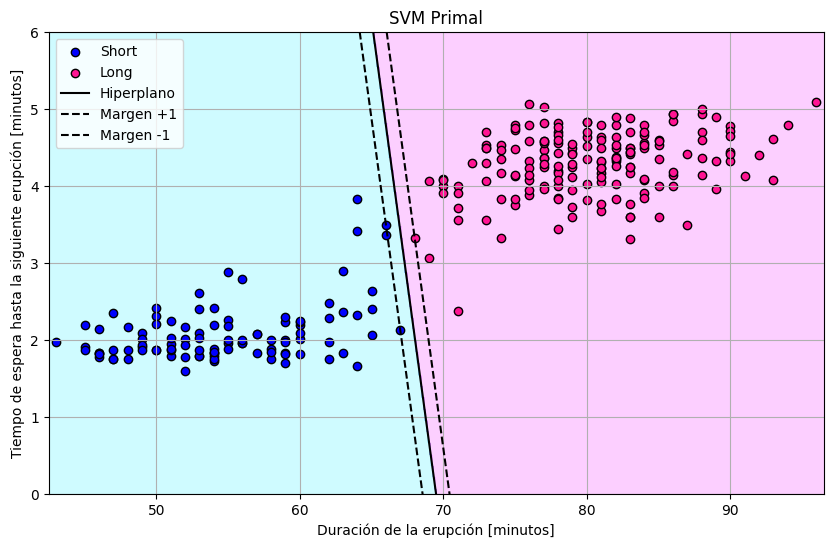

In [36]:
class SVM:
    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Matrices para el problema primal
        P = np.zeros((n_features + 1, n_features + 1))
        P[:n_features, :n_features] = np.eye(n_features)
        q = np.zeros(n_features + 1)

        G = np.zeros((n_samples, n_features + 1))
        h = -np.ones(n_samples)
        for i in range(n_samples):
            G[i, :-1] = -y[i] * X[i]
            G[i, -1] = -y[i]

        # Resolver
        sol = solve_qp(P, q, G, h, solver='osqp')
        self.w = sol[:n_features]
        self.b = sol[-1]

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

# Entrenar SVM
modelo = SVM()
modelo.fit(X, y)

# Crear grilla para graficar frontera
def create_meshgrid(X, y_min=0, y_max=6, steps=500):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    return xx, yy

def decision_boundary(x, w, b, offset=0):
    return -(w[0] * x + b + offset) / w[1]

def flexible_plot_svm_decision_boundary(model, X, y, title="", show_violations=False, ax=None):
    xx, yy = create_meshgrid(X)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.contourf(xx, yy, Z, alpha=0.2, cmap='cool')

    shorts = X[y == -1]
    longs = X[y == 1]

    if show_violations:
        margins = y * (X @ model.w + model.b)
        inside_margin = (margins < 1)
        ax.scatter(X[inside_margin, 0], X[inside_margin, 1], facecolors='none', edgecolors='red', label='Violaciones')

    ax.scatter(shorts[:, 0], shorts[:, 1], c='blue', label='Short', edgecolors='k')
    ax.scatter(longs[:, 0], longs[:, 1], c='deeppink', label='Long', edgecolors='k')

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x_vals = np.linspace(x_min, x_max, 500)
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b), 'k-', label='Hiperplano')
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b, offset=1), 'k--', label='Margen +1')
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b, offset=-1), 'k--', label='Margen -1')

    ax.set_title(title)
    ax.set_xlabel('Duración de la erupción [minutos]')
    ax.set_ylabel('Tiempo de espera hasta la siguiente erupción [minutos]')
    ax.set_ylim(0, 6)
    ax.legend()
    ax.grid(True)

    if ax is None:
        plt.show()


# Graficar
flexible_plot_svm_decision_boundary(modelo, X, y, "SVM Primal")

Se crearon las funciones `create_meshgrid`, `decision_boundary` y `flexible_plot_svm_decision_boundary` para luego ser utilizadas como plots o subplots en los siguientes ejercicios. 


___
### Problema dual y márgenes relajados
#### <u>(c) Repetir el inciso (b) resolviendo el problema dual.</u>


**¿Qué cambia en el problema **dual** del SVM?**

En lugar de optimizar sobre $ w $ y $ b $ directamente, en el **dual**:

- Optimizamos sobre los **multiplicadores de Lagrange $ \alpha_i $**.
- Ya no trabajamos directamente con $ w $ ni $ b $.
- El dataset aparece **solo** a través de los productos escalares $ x_i^T x_j $.

**📃 Formulación matemática del dual**

1. **Partimos del problema primal**

    Queremos resolver:

$$
\min_{w,b} \quad \frac{1}{2} \|w\|^2 \quad \text{sujeto a} \quad y_i (w^T x_i + b) \geq 1 \quad (\forall i)
$$

- Minimizar el tamaño de $w $ (maximizar margen).
- Clasificar correctamente con margen $\geq 1 $.

2. **Construcción de la Lagrangiana**

    Armamos la Lagrangiana:

    $$
    L(w,b,\alpha) = \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i [ y_i (w^T x_i + b) - 1 ]
    $$

    - Cada restricción tiene un multiplicador $\alpha_i \geq 0 $.


3. **Aplicación de condiciones KKT**

    a. Derivar respecto de $w $ y anular:

    $$
    \frac{\partial L}{\partial w} = 0 \quad \Rightarrow \quad w = \sum_{i=1}^n \alpha_i y_i x_i
    $$


    b. Derivar respecto de $b $ y anular:

    $$
    \frac{\partial L}{\partial b} = 0 \quad \Rightarrow \quad \sum_{i=1}^n \alpha_i y_i = 0
    $$

    c. Condiciones de positividad:

    $$
    \alpha_i \geq 0
    $$


4. **Reemplazo y simplificación**

    Reemplazamos $w $ en la Lagrangiana y simplificamos:

    $$
    \max_{\alpha} \quad \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j (x_i^T x_j)
    $$


    sujeto a:

$$
\sum_i \alpha_i y_i = 0, \quad \alpha_i \geq 0
$$


**🛠️ ¿Cómo se arma para `solve_qp`?**

Recordemos que `solve_qp` resuelve:

$$
\min_x \quad \frac{1}{2} x^T P x + q^T x
$$
sujeto a:

$$
Gx \leq h, \quad Ax = b
$$

Por lo tanto, en el **dual**:

- `P = Q`, donde $ Q_{ij} = y_i y_j (x_i^T x_j) $.
- `q = -1` (vector de $ -1 $).
- `G = -I` (matriz identidad negativa, para $ \alpha_i \geq 0 $).
- `h = 0` (vector de ceros).
- `A = y^T` (vector de etiquetas transpuesto).
- `b = 0` (escalares).

**💡 Reconstruir w y b luego de resolver**

Una vez que obtenemos los $ \alpha $, reconstruimos:

$$
w = \sum_i \alpha_i y_i x_i
$$

y calculamos $ b $ usando los vectores soporte.


**🌟 Resumen visual**

| Aspecto | Primal | Dual |
|:---|:---|:---|
| Variables | $ w, b $ | $ \alpha $ |
| Solución directa | Sí | No, hay que reconstruir |
| Dataset aparece como | $ x $ | Productos escalares $ x_i^T x_j $ |
| Ventajas | Mejor para pocos features | Mejor para muchos features y kernels |



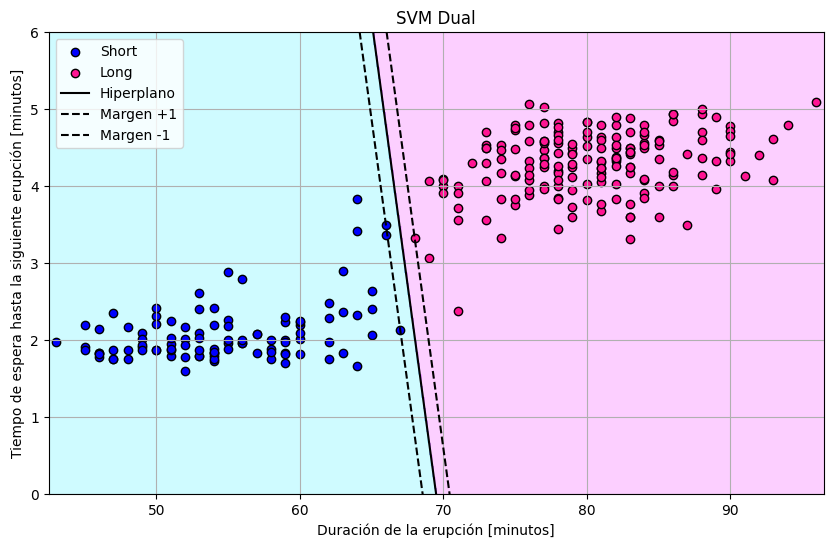

In [37]:
class SVM_Dual:
    def __init__(self):
        self.alpha = None
        self.w = None
        self.b = None
        self.support_vectors_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Matriz de Gram (producto escalar entre puntos)
        K = X @ X.T
        Q = np.outer(y, y) * K

        # Definimos los elementos del problema para solve_qp
        P = Q
        q = -np.ones(n_samples)
        G = -np.eye(n_samples)
        h = np.zeros(n_samples)
        A = y.astype(float).reshape(1, -1)
        b = np.array([0.])

        # Resolver el problema dual
        alphas = solve_qp(P, q, G, h, A, b, solver="cvxopt")
        self.alpha = alphas

        # Reconstruir el vector w
        self.w = ((self.alpha * y)[:, None] * X).sum(axis=0)

        # Identificar vectores soporte (alphas > 0)
        support_idx = self.alpha > 1e-5
        self.support_vectors_ = X[support_idx]

        # Calcular el bias b usando los vectores soporte
        self.b = np.mean(y[support_idx] - X[support_idx] @ self.w)

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

# Entrenar SVM Dual
modelo_dual = SVM_Dual()
modelo_dual.fit(X, y)

flexible_plot_svm_decision_boundary(modelo_dual, X, y, "SVM Dual")



#### <u>(d) Repetir el inciso (b) relajando los márgenes (utilizando $ C = 0.001 $ y $ C = 0.1 $) y resolviendo el problema primal.</u>

**📚 ¿Qué significa "relajar los márgenes" usando $ C = 0.001 $ y $ C = 0.1 $?**

En **SVM de márgenes duros**:
- Todos los puntos deben quedar **perfectamente separados**.
- No se permiten errores ni puntos dentro del margen.

Problema primal clásico:
$$
\min \quad \frac{1}{2} \|w\|^2 \quad \text{sujeto a} \quad y_i(w^T x_i + b) \geq 1
$$


Cuando decimos **relajar los márgenes**:
- Permitimos que algunos puntos **no cumplan perfectamente** la condición.
- Introducimos **variables de holgura** $ \xi_i \geq 0 $ que miden **cuánto se viola el margen**.

**Problema primal soft margin:**

$$
\min \quad \frac{1}{2} \|w\|^2 + C \sum_i \xi_i
$$

sujeto a:

$$
y_i(w^T x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

**Relajar** significa **aceptar errores** para conseguir una solución más flexible.

El parámetro $ C $ controla **cuánto penalizamos** esas violaciones:
- $ C $ grande = más exigente.
- $ C $ pequeño = más tolerante.


| Aspecto | $ C = 0.001 $ (muy chico) | $ C = 0.1 $ (más grande) |
|:---|:---|:---|
| Penalización de errores | Muy baja | Más alta |
| Permite más violaciones | ✅ Sí | ❌ Menos |
| El margen es | Más ancho | Más estricto |
| El hiperplano puede | No separar tan bien | Separar mejor |


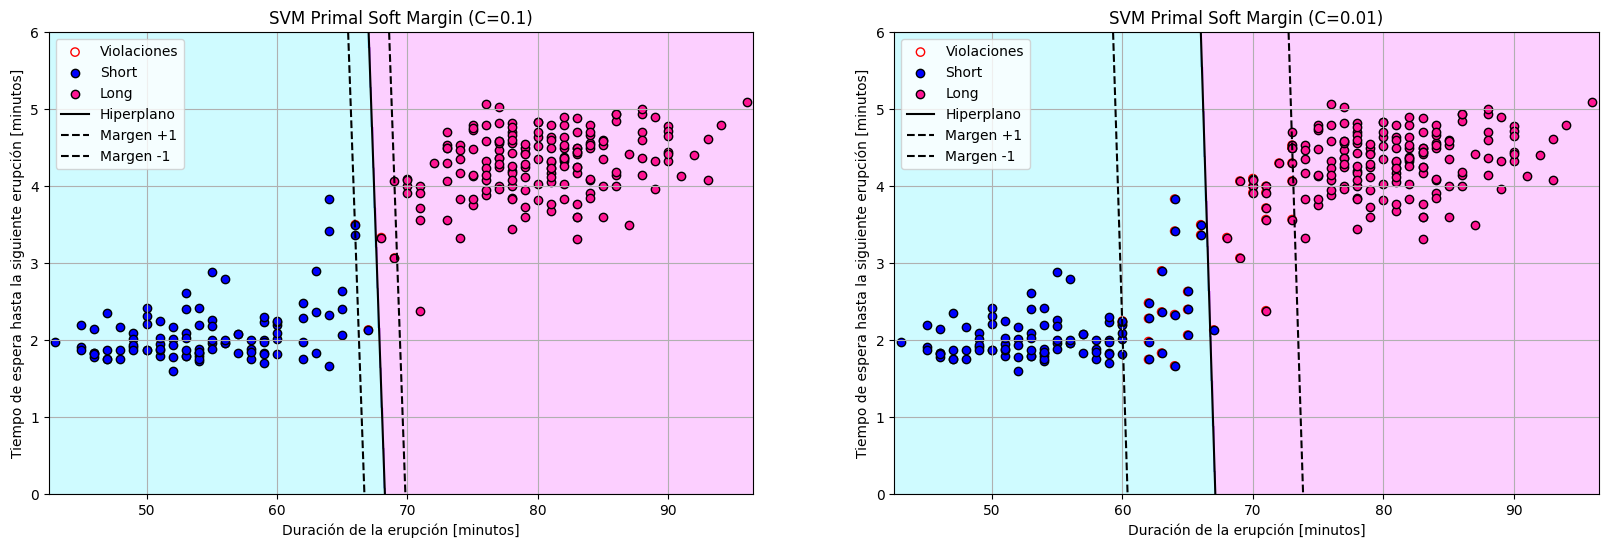

In [45]:
class SVM_Primal_Soft:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.slack = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_variables = n_features + 1 + n_samples

        # Matriz P
        P = np.zeros((n_variables, n_variables))
        P[:n_features, :n_features] = np.eye(n_features)

        # Vector q
        q = np.zeros(n_variables)
        q[n_features+1:] = self.C

        # Matriz G y vector h
        G = np.zeros((n_samples * 2, n_variables))
        h = np.zeros(n_samples * 2)

        for i in range(n_samples):
            G[i, :n_features] = -y[i] * X[i]
            G[i, n_features] = -y[i]
            G[i, n_features + 1 + i] = -1
            h[i] = -1

        for i in range(n_samples):
            G[n_samples + i, n_features + 1 + i] = -1
            h[n_samples + i] = 0

        # Resolver
        sol = solve_qp(P, q, G, h, solver='osqp')

        self.w = sol[:n_features]
        self.b = sol[n_features]
        self.slack = sol[n_features+1:]

    def predict(self, X):
        return np.sign(X @ self.w + self.b)


# Probar con C = 0.001 y C = 0.1
modelo_soft = SVM_Primal_Soft(C=0.1)
modelo_soft.fit(X, y)
modelo_soft_001 = SVM_Primal_Soft(C=0.001)
modelo_soft_001.fit(X, y)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.ravel()
flexible_plot_svm_decision_boundary(modelo_soft, X, y, title="SVM Primal Soft Margin (C=0.1)", show_violations=True, ax=axs[0])
flexible_plot_svm_decision_boundary(modelo_soft_001, X, y, title="SVM Primal Soft Margin (C=0.01)", show_violations=True, ax=axs[1])




### <u>(e) Hallar el problema dual con márgenes relajados. Efectuar el desarrollo matemático de la misma.</u>


**📚 Partimos del problema primal relajado**

Planteamos:

$$
\min_{w, b, \xi} \quad \frac{1}{2}\|w\|^2 + C \sum_{i=1}^{n} \xi_i
$$

sujeto a:

$$
 y_i (w^T x_i + b) \geq 1 - \xi_i \quad \forall i
$$
$$
 \xi_i \geq 0 \quad \forall i
$$


**📊 Construcción de la Lagrangiana**

Introducimos multiplicadores de Lagrange:
- $ \alpha_i \geq 0 $ para las restricciones de separación.
- $ \beta_i \geq 0 $ para las restricciones de positividad de $ \xi_i $.

La Lagrangiana es:

$$
\mathcal{L}(w, b, \xi, \alpha, \beta) = \frac{1}{2}\|w\|^2 + C \sum_{i=1}^{n} \xi_i - \sum_{i=1}^{n} \alpha_i [y_i (w^T x_i + b) - 1 + \xi_i] - \sum_{i=1}^{n} \beta_i \xi_i
$$


**🧐 Condiciones de estacionaridad (KKT)**

Calculamos las derivadas parciales y anulamos:

- Respecto de $ w $:
$$
\frac{\partial \mathcal{L}}{\partial w} = w - \sum_{i=1}^{n} \alpha_i y_i x_i = 0 \quad \Rightarrow \quad w = \sum_{i=1}^{n} \alpha_i y_i x_i
$$

- Respecto de $ b $:
$$
\frac{\partial \mathcal{L}}{\partial b} = -\sum_{i=1}^{n} \alpha_i y_i = 0 \quad \Rightarrow \quad \sum_{i=1}^{n} \alpha_i y_i = 0
$$

- Respecto de $ \xi_i $:
$$
\frac{\partial \mathcal{L}}{\partial \xi_i} = C - \alpha_i - \beta_i = 0 \quad \Rightarrow \quad \alpha_i + \beta_i = C
$$

Además de las restricciones de $ \alpha_i, \beta_i \geq 0 $.


**🔄 Simplificaciones**

- Al reemplazar $ w $, el término cuadrático queda:
$$
\frac{1}{2}\left(\sum_{i=1}^{n} \alpha_i y_i x_i \right)^T\left(\sum_{j=1}^{n} \alpha_j y_j x_j \right) = \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \langle x_i, x_j \rangle
$$

- El término lineal con $ b $ desaparece porque $ \sum \alpha_i y_i = 0 $.

- Los términos que contienen $ \xi_i $ se anulan:
$$
C \sum \xi_i - \sum \alpha_i \xi_i - \sum \beta_i \xi_i = 0
$$

ya que $ \alpha_i + \beta_i = C $.


**📅 Problema dual final**

Finalmente, el problema dual es:

$$
\max_{\alpha} \quad \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \langle x_i, x_j \rangle
$$

sujeto a:

$$
0 \leq \alpha_i \leq C \quad \forall i
$$
$$
\sum_{i=1}^{n} \alpha_i y_i = 0
$$


**🔥 Cambios respecto al dual de márgenes duros**

| Aspecto | Márgenes duros | Márgenes relajados |
|:---|:---|:---|
| Restricción en $ \alpha_i $ | $ \alpha_i \geq 0 $ | $ 0 \leq \alpha_i \leq C $ |
| Penalización de errores | No existe | Presente mediante $ C $ |
| Tolerancia a errores | No | Sí |




#### <u>(f) Repetir el inciso (b) relajando los márgenes (utilizando \( C = 0.001 \) y \( C = 0.1 \)) y resolviendo el problema dual</u>



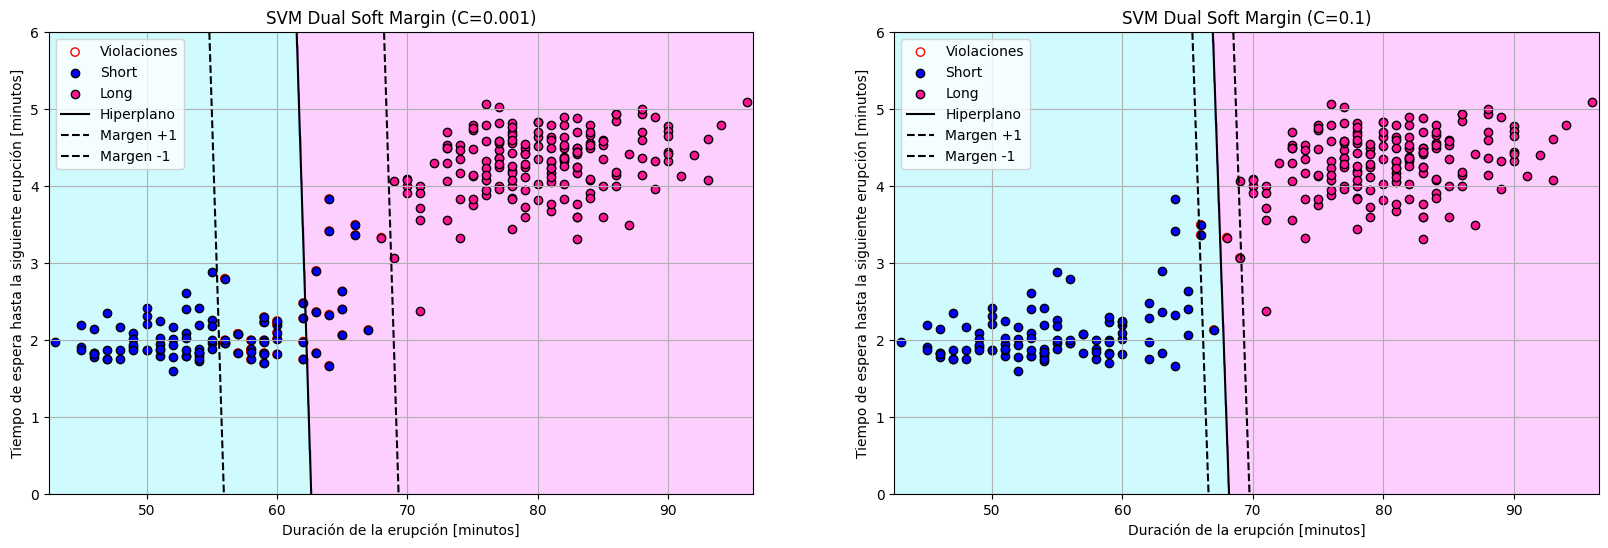

In [43]:
class SVM_Dual_Soft:
    def __init__(self, C=1.0):
        self.C = C
        self.alpha = None
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Matriz Q para el problema dual
        K = X @ X.T
        Q = np.outer(y, y) * K

        P = Q
        q = -np.ones(n_samples)

        # Restricciones: 0 <= alpha_i <= C
        G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
        h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C])

        # Restricción de igualdad: sum(alpha_i * y_i) = 0
        A = y.reshape(1, -1)
        b = np.array([0.])

        # Resolver el problema dual
        alpha = solve_qp(P, q, G, h, A, b, solver='osqp')
        self.alpha = np.array(alpha)

        # Reconstruir w y b
        self.w = ((self.alpha * y)[:, None] * X).sum(axis=0)
        support_vectors = (self.alpha > 1e-5)
        self.b = np.mean(y[support_vectors] - X[support_vectors] @ self.w)

    def predict(self, X):
        return np.sign(X @ self.w + self.b)
    

modelo_dual_soft = SVM_Dual_Soft(C=0.1)
modelo_dual_soft.fit(X, y)
modelo_dual_soft_001 = SVM_Dual_Soft(C=0.001)
modelo_dual_soft_001.fit(X, y)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.ravel()
flexible_plot_svm_decision_boundary(modelo_dual_soft_001, X, y, title=f'SVM Dual Soft Margin (C=0.001)', show_violations=True, ax=axs[0])
flexible_plot_svm_decision_boundary(modelo_dual_soft, X, y, title='SVM Dual Soft Margin (C=0.1)', show_violations=True, ax=axs[1])




#### <u>(g)Utilizando `subplots` (pyplot) mostrar los 6 gráficos en una misma figura. Extraer conclusiones.</u>


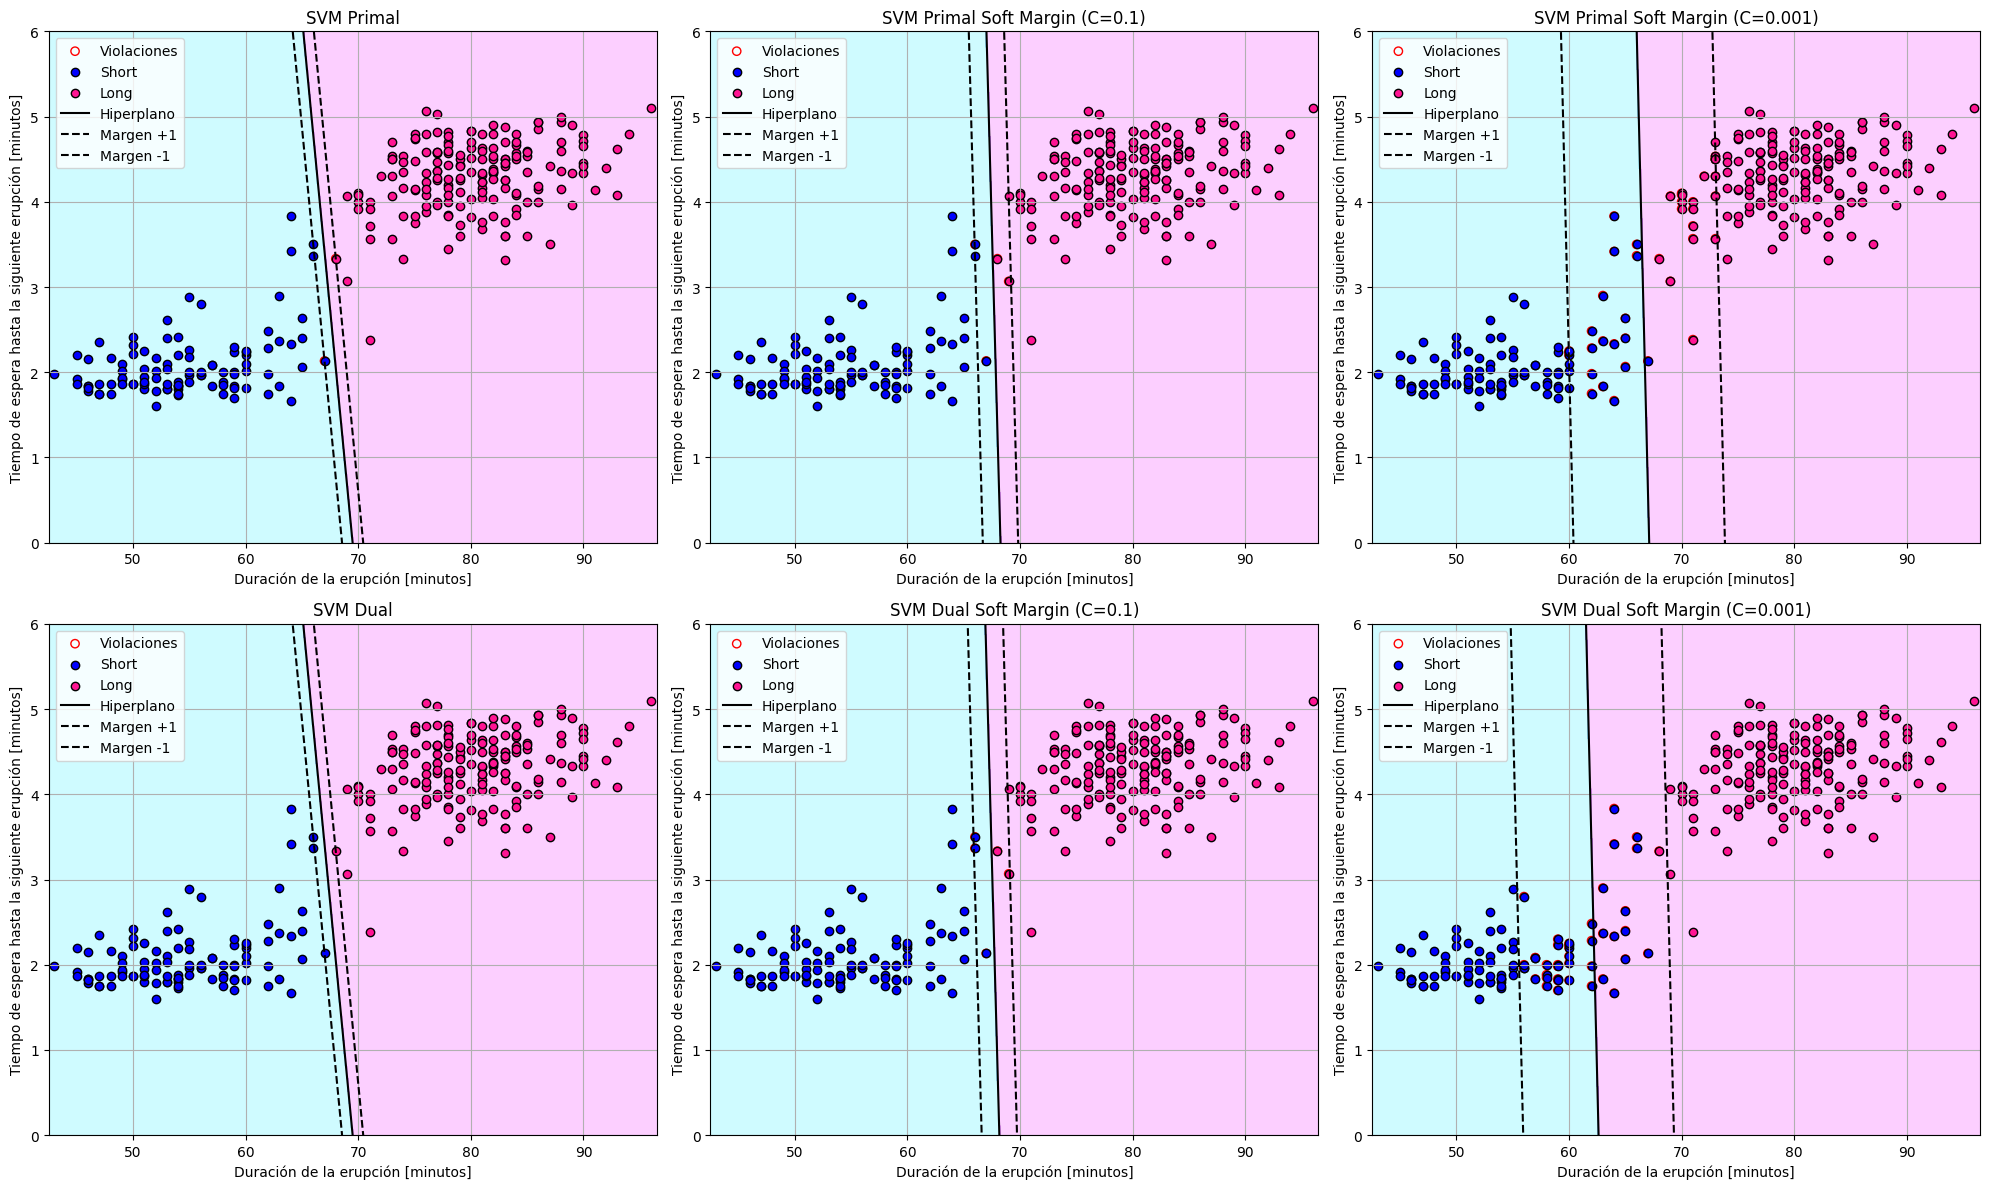

In [ ]:
def subplot_svm_decision_boundary(ax, model, X, y, title="", show_violations=False):
    xx, yy = create_meshgrid(X)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.2, cmap='cool')

    shorts = X[y == -1]
    longs = X[y == 1]

    if show_violations:
        margins = y * (X @ model.w + model.b)
        inside_margin = (margins < 1)
        ax.scatter(X[inside_margin, 0], X[inside_margin, 1], facecolors='none', edgecolors='red', label='Violaciones')

    ax.scatter(shorts[:, 0], shorts[:, 1], c='blue', label='Short', edgecolors='k')
    ax.scatter(longs[:, 0], longs[:, 1], c='deeppink', label='Long', edgecolors='k')

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x_vals = np.linspace(x_min, x_max, 500)
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b), 'k-', label='Hiperplano')
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b, offset=1), 'k--', label='Margen +1')
    ax.plot(x_vals, decision_boundary(x_vals, model.w, model.b, offset=-1), 'k--', label='Margen -1')

    ax.set_title(title)
    ax.set_xlabel('Duración de la erupción [minutos]')
    ax.set_ylabel('Tiempo de espera hasta la siguiente erupción [minutos]')
    ax.set_ylim(0, 6)
    ax.legend()
    ax.grid(True)

modelos = [
    modelo,
    modelo_soft,
    modelo_soft_001,
    modelo_dual,
    modelo_dual_soft,
    modelo_dual_soft_001
]

titulos = [
    "SVM Primal",
    "SVM Primal Soft Margin (C=0.1)",
    "SVM Primal Soft Margin (C=0.001)",
    "SVM Dual",
    "SVM Dual Soft Margin (C=0.1)",
    "SVM Dual Soft Margin (C=0.001)"
]

fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

for i, (modelo, titulo) in enumerate(zip(modelos, titulos)):
    flexible_plot_svm_decision_boundary( modelo, X, y, title=titulo, show_violations=True, ax=axs[i])

plt.tight_layout()
plt.show()



##### 1. **SVM Primal**
- Modelo sin permitir errores.
- Hiperplano **perfectamente ajustado**.
- **No hay violaciones**.
- **Margen máximo** logrado.

##### 2. **SVM Primal Soft Margin (C = 0.1)**
- Permite **algunos errores**.
- Aparecen **pocos puntos violando** el margen.
- **Margen ligeramente más amplio**.


##### 3. **SVM Primal Soft Margin (C = 0.001)**
- **Muchos errores** permitidos.
- **Margen más ancho**.
- Hiperplano **se mueve** para tolerar más ruido.

##### 4. **SVM Dual**
- Dual sin errores.
- Resultado **muy similar** al primal.
- **Confirma** que primal y dual son equivalentes en problemas linealmente separables.

##### 5. **SVM Dual Soft Margin (C = 0.1)**
- Dual blando.
- **Resultados muy similares** al primal soft.
- **Errores controlados**.


##### 6. **SVM Dual Soft Margin (C = 0.001)**
- Igual comportamiento que primal soft con C pequeño.
- **Alta tolerancia** a errores.



#####  📊 Conclusiones generales

| Observación | Explicación |
|:---|:---|
| C grande (Primal/Dual duros) | Separación estricta, sin errores, margen finito. |
| C = 0.1 | Se permiten algunos errores, hiperplano más flexible. |
| C = 0.001 | Muchos errores permitidos, margen ancho, mejor generalización al ruido. |
| Primal vs Dual | Resultados equivalentes en datos lineales.|


**📚 ¿Por qué no hay tanta diferencia entre el SVM dual y el primal?**

Porque el problema es linealmente separable. El dataset (geyser) ya es separable (o casi separable) en el espacio original (duración vs. espera). En este caso, no se necesita ningún truco especial (como kernels). Entonces resolver el primal o el dual lleva al mismo hiperplano.

